## Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


## Data upload

In [33]:
train_df = pd.read_csv("../data/ml_ozon_сounterfeit_train.csv")

train_df['item_time_alive_log'] = np.log1p(train_df['item_time_alive'])  # log(1 + x)

## Data analysis

Пропуски

In [43]:
mv = train_df.isna().sum().sort_values(ascending=False)
mv = mv[mv > 0]
miss = pd.DataFrame({'missing': mv, 'missing_%': (mv / len(train_df) * 100).round(2)})
display(miss.head(30))


,missing,missing_%
comments_published_count,150005,76.07
rating_5_count,150005,76.07
rating_4_count,150005,76.07
rating_3_count,150005,76.07
rating_2_count,150005,76.07
rating_1_count,150005,76.07
photos_published_count,150005,76.07
videos_published_count,150005,76.07
brand_name,80531,40.84
description,26060,13.22


Распределение классов

C:\Users\Kostya\AppData\Local\Temp\ipykernel_12840\1091904863.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="resolution", data=train_df, palette="Set2")


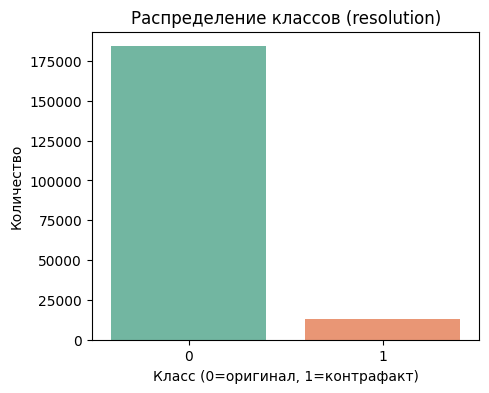

resolution
0    0.933813
1    0.066187
Name: proportion, dtype: float64


In [34]:
plt.figure(figsize=(5,4))
sns.countplot(x="resolution", data=train_df, palette="Set2")
plt.title("Распределение классов (resolution)")
plt.xlabel("Класс (0=оригинал, 1=контрафакт)")
plt.ylabel("Количество")
plt.show()

print(train_df["resolution"].value_counts(normalize=True))

Распредление длины в описании и названии


=== DESCRIPTION | resolution=0 ===
Средняя длина (слов): 43.0
Медиана: 45
90-й перцентиль: 81

=== DESCRIPTION | resolution=1 ===
Средняя длина (слов): 49.8
Медиана: 67
90-й перцентиль: 80


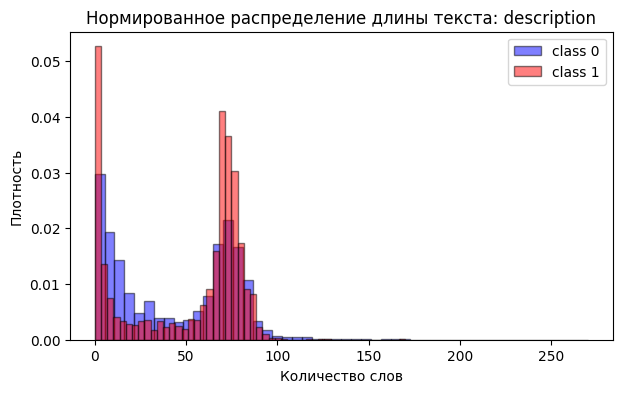


=== NAME_RUS | resolution=0 ===
Средняя длина (слов): 10.1
Медиана: 9
90-й перцентиль: 16

=== NAME_RUS | resolution=1 ===
Средняя длина (слов): 8.0
Медиана: 7
90-й перцентиль: 14


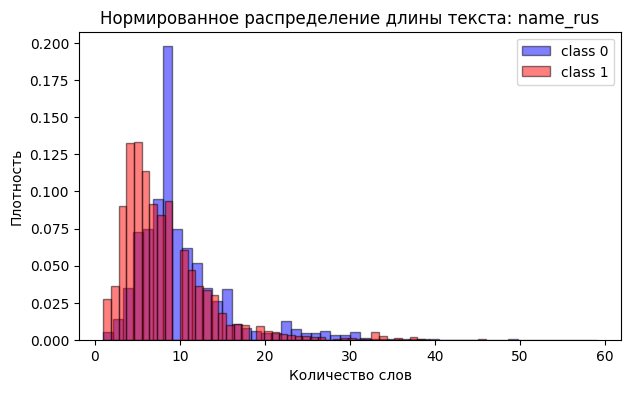

In [35]:
import numpy as np
import matplotlib.pyplot as plt

for col in ["description", "name_rus"]:
    plt.figure(figsize=(7,4))
    for cls, color in zip([0, 1], ["blue", "red"]):
        subset = train_df[train_df["resolution"] == cls][col].fillna("")
        lengths = subset.apply(lambda x: len(str(x).split()))
        
        print(f"\n=== {col.upper()} | resolution={cls} ===")
        print(f"Средняя длина (слов): {lengths.mean():.1f}")
        print(f"Медиана: {lengths.median():.0f}")
        print(f"90-й перцентиль: {np.percentile(lengths, 90):.0f}")
        
        plt.hist(lengths, bins=50, density=True, alpha=0.5,
                 label=f"class {cls}", color=color, edgecolor="black")
    
    plt.title(f"Нормированное распределение длины текста: {col}")
    plt.xlabel("Количество слов")
    plt.ylabel("Плотность")
    plt.legend()
    plt.show()


TOP-слова в описании

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

def top_words_for_class(texts, labels, target_class, n=15):
    vect = CountVectorizer(max_features=20000)
    X = vect.fit_transform(texts.fillna(""))
    y = labels.values  
    idx = (y == target_class)
    word_counts = np.array(X[idx].sum(axis=0)).flatten()
    vocab = np.array(vect.get_feature_names_out())
    top_idx = word_counts.argsort()[::-1][:n]
    return list(zip(vocab[top_idx], word_counts[top_idx]))

for cls in [0, 1]:
    print(f"\n🔹 Топ-слов для класса {cls}:")
    for w, c in top_words_for_class(train_df["description"], train_df["resolution"], cls):
        print(f"{w}: {c}")



🔹 Топ-слов для класса 0:
br: 516674
для: 206532
samsung: 134297
li: 111806
на: 76464
не: 44953
от: 39796
что: 30956
при: 30486
из: 29647
мм: 27726
philips: 27604
xiaomi: 26156
np: 24669
подходит: 24390

🔹 Топ-слов для класса 1:
br: 28153
для: 12489
li: 6542
на: 6443
не: 3149
от: 3011
что: 2939
наушники: 2939
вы: 2857
благодаря: 2733
или: 2613
обеспечивает: 2607
это: 2601
до: 2233
позволяет: 2155


Корреляция с тагретом

C:\Users\Kostya\AppData\Local\Temp\ipykernel_12840\3460169805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")


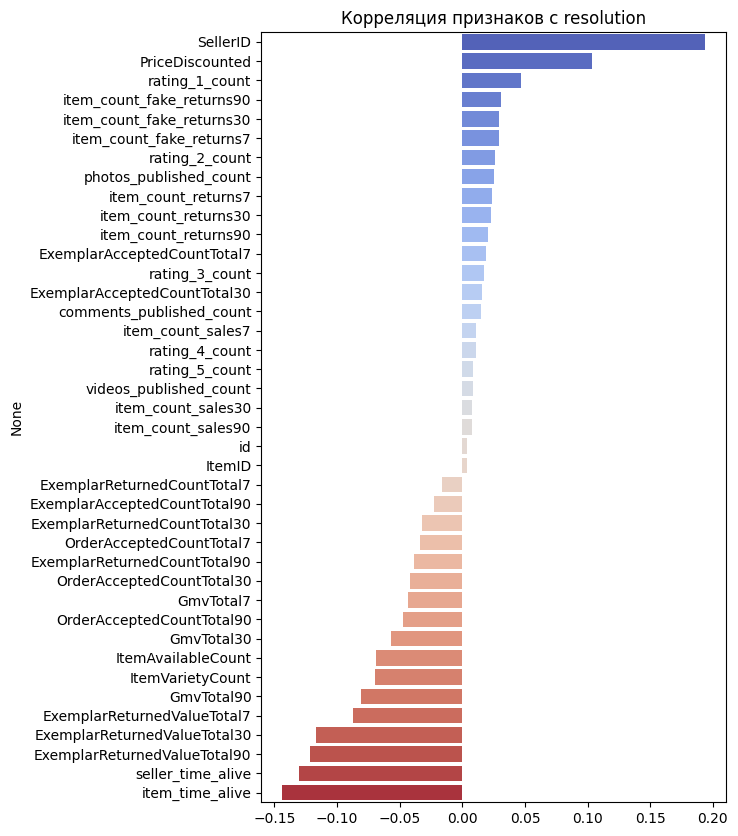

In [84]:
num_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
corr = train_df[num_cols].corrwith(train_df["resolution"]).sort_values(ascending=False)
corr = corr.drop("resolution")
plt.figure(figsize=(6,10))
sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
plt.title("Корреляция признаков с resolution")
plt.show()


Распределение TOP-10 фич по корреляции с таргетом(нормированное - контрит дисбаланс классов)

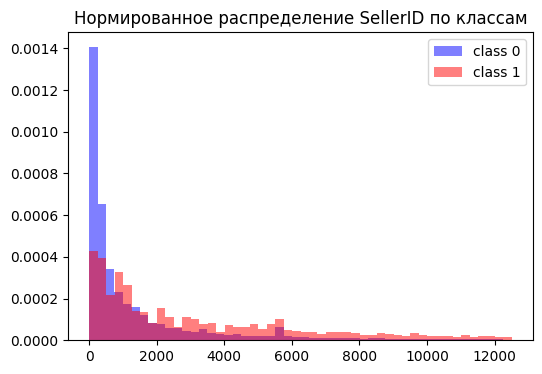

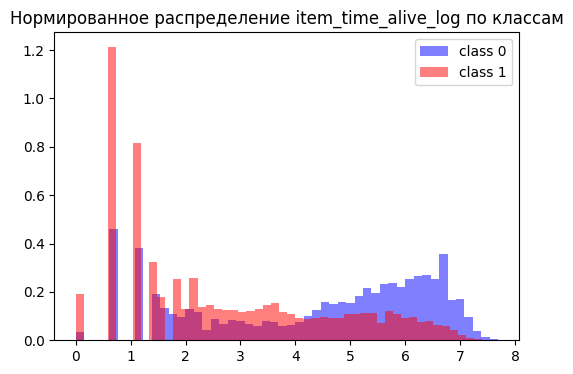

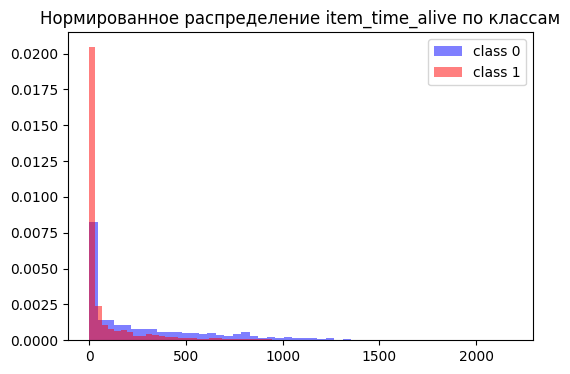

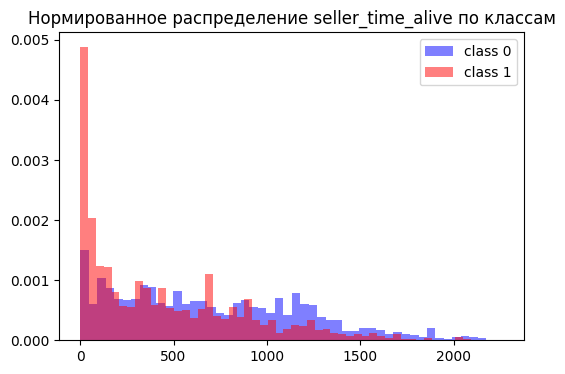

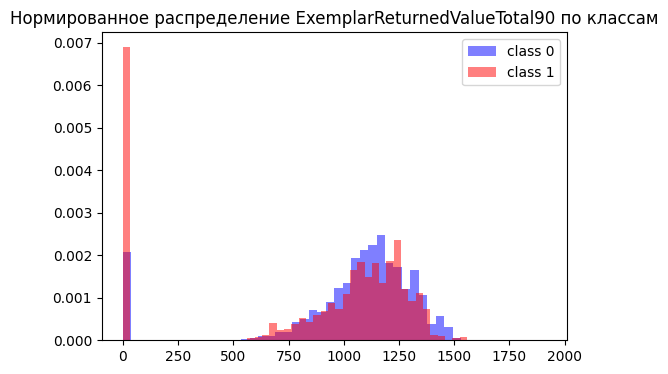

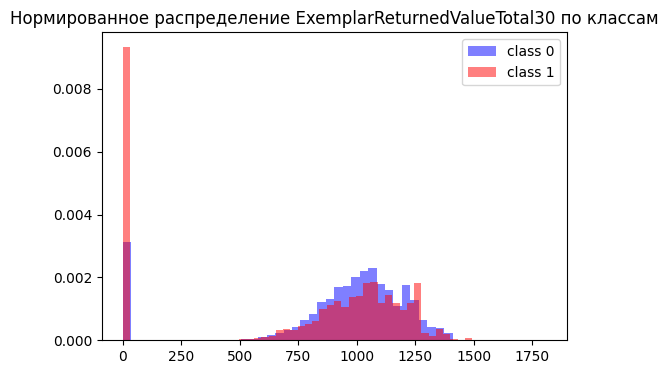

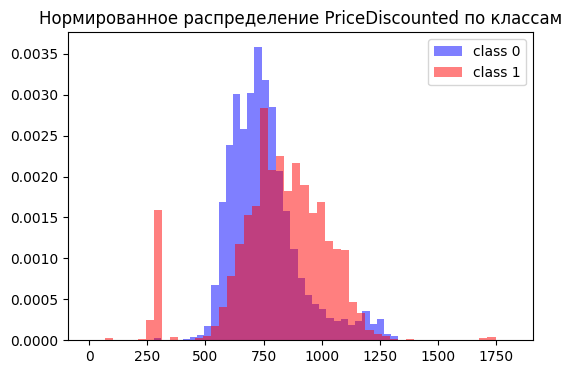

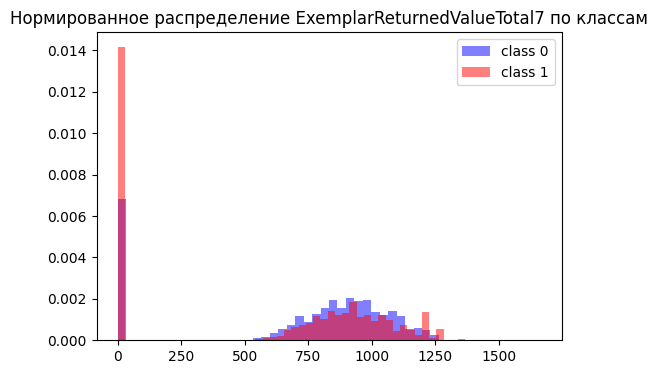

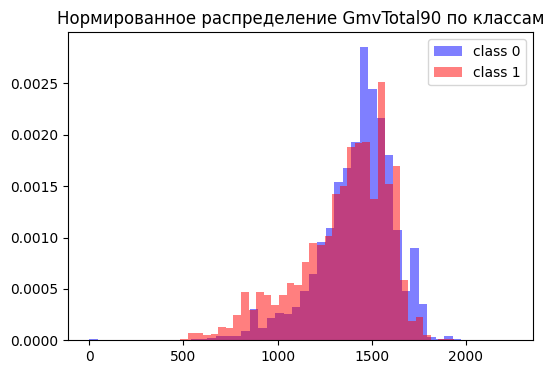

In [38]:
top_feats = corr.abs().sort_values(ascending=False).head(10).index.drop("resolution")

for col in top_feats:
    plt.figure(figsize=(6,4))
    for cls, color in zip([0,1], ["blue","red"]):
        plt.hist(train_df[train_df["resolution"]==cls][col], 
                 bins=50, density=True, alpha=0.5, color=color, label=f"class {cls}")
    plt.title(f"Нормированное распределение {col} по классам")
    plt.legend()
    plt.show()


In [39]:
print("Пропуски в brand_name по классам:")
print(train_df.groupby("resolution")["brand_name"].apply(lambda x: x.isna().mean()))

print("\nТоп-10 брендов по каждому классу:")
for cls in [0,1]:
    top_brands = (train_df[train_df["resolution"]==cls]["brand_name"]
                  .value_counts()
                  .head(10))
    print(f"\nКласс {cls}:")
    print(top_brands)

Пропуски в brand_name по классам:
resolution
0    0.394611
1    0.602590
Name: brand_name, dtype: float64

Топ-10 брендов по каждому классу:

Класс 0:
brand_name
iQZiP            6060
ProFDetali       4808
OEM              4236
Levsha kaluga    2994
HUAYU            2743
OINO             2739
Sony             2453
HotComputers     2391
Cameron Sino     2055
MyPads           1955
Name: count, dtype: int64

Класс 1:
brand_name
Sony                600
Mivis               436
Logitech G          299
Pioneer             167
Philips Sonicare    131
Redmi               124
Kingston Fury       121
Art-Gsm              97
Mijia                85
LISIK.               82
Name: count, dtype: int64


Минимальное значение item_time_alive: 0


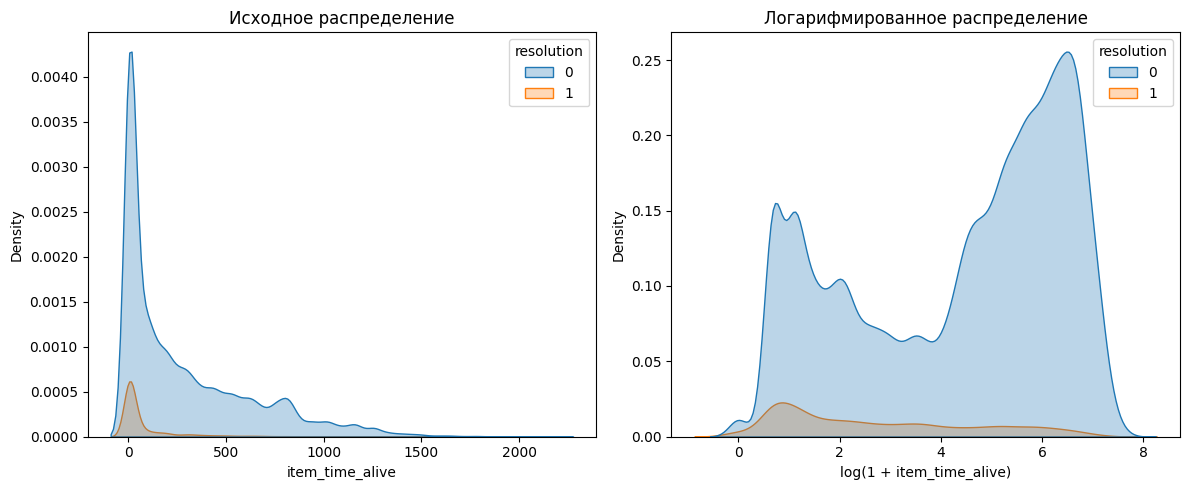

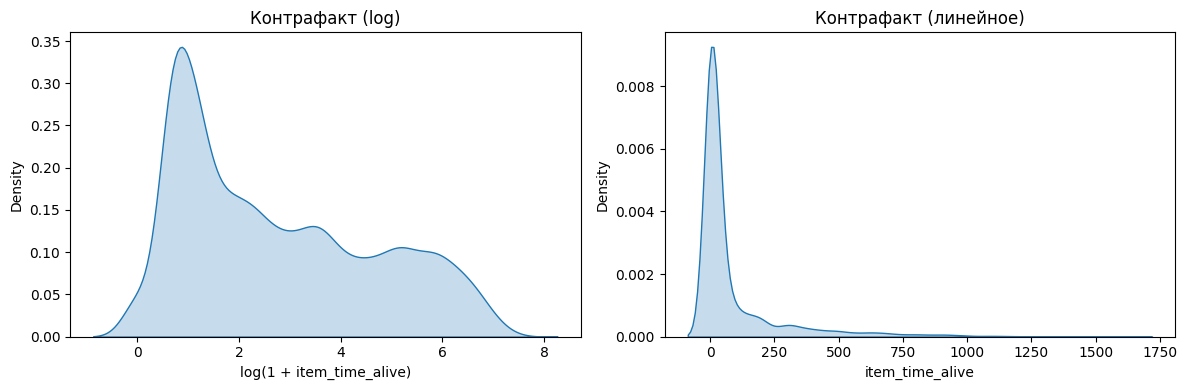

In [40]:
print("Минимальное значение item_time_alive:", train_df['item_time_alive'].min())

train_df['item_time_alive_log'] = np.log1p(train_df['item_time_alive'])  # log(1 + x)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=train_df, x='item_time_alive', hue='resolution', fill=True, alpha=0.3)
plt.title('Исходное распределение')
plt.xlabel('item_time_alive')

plt.subplot(1, 2, 2)
sns.kdeplot(data=train_df, x='item_time_alive_log', hue='resolution', fill=True, alpha=0.3)
plt.title('Логарифмированное распределение')
plt.xlabel('log(1 + item_time_alive)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(data=train_df[train_df['resolution'] == 1], x='item_time_alive_log', fill=True)
plt.title('Контрафакт (log)')
plt.xlabel('log(1 + item_time_alive)')

plt.subplot(1, 2, 2)
sns.kdeplot(data=train_df[train_df['resolution'] == 1], x='item_time_alive', fill=True)
plt.title('Контрафакт (линейное)')
plt.xlabel('item_time_alive')

plt.tight_layout()
plt.show()

## Images analysis


ID 97026
Название: Системный блок (Intel Core i5-10400F, RAM 32 ГБ, SSD 120 ГБ, AMD Radeon RX 580 (8 Гб), Windows 10 Pro), белый
Описание: Системный блок для дома и офиса.
Современные и надёжные комплектующие в совокупе с качественной и бережной сборкой обеспечат Вам стабильную быструю работу на долгое время. 
Представленная сборка позволит закрыть все ежедневные потребности пользователя от офисных программ и веб-сёрфинга до лёгких и нетребовательных игр, просмотра видео-контента в хорошем качестве.
Вместе с этим Вы получаете уже активированную лицензионную операционную систему Windows 10 Pro, делая системный блок готовым к работе сразу после распаковки.
Минималистичный дизайн с ярким цвет...

ID 174081
Название: Картридж Sakura D101S для Samsung
Описание: Картридж Sakura D101S для Samsung ML-2160/2165/2167/2168/SCX-3400/3405/3407 черный 1500стр...

ID 80314
Название: Пылесос Karcher VC 6 Cordless ourFamily Limited Edition 1.198-662
Описание: Пылесос с универсальными возможностями: "2 

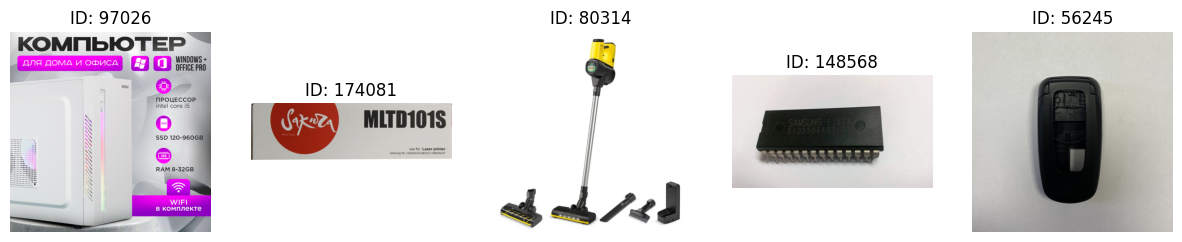

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

test_df = pd.read_csv("../data/ml_ozon_сounterfeit_test.csv")

test_img_folder = "C:/Users/Kostya/Desktop/CodeNRockHack/CounterfeitDetector/data/ml_ozon_сounterfeit_test_images"

sample = test_df.dropna(subset=["description"]).sample(5, random_state=42)

plt.figure(figsize=(15,10))
for i, row in enumerate(sample.itertuples(), 1):
    img_path = os.path.join(img_folder, f"{row.ItemID}.png")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"ID: {row.ItemID}")
        print(f"ID {row.ItemID}\n"
              f"Название: {row.name_rus}\n"
              f"Описание: {row.description}...\n")

plt.show()

ID 16354 | res=0
Название: Аккумулятор iPhone 6 -1810 mAh - Pisen (Apple )
Описание: Аккумулятор Pisen для iPhone 6 (Apple) -1810 mAh представляет собой качественную и надежную запчасть для вашего мобильного телефона. Он обеспечивает продолжительное время работы и стабильное питание устройства, благодаря повышенной емкости аккумулятора в 1810 mAh и усиленной конструкции аккумулятора.

Совместимость и емкость: аккумулятор разработан специально для Apple iPhone 6, а также iPod/iPhone.

Стильный черный цвет аккумулятора гармонично сочетается с дизайном вашего устройства, не выделяя его на общем фоне и не портя внешний вид.

Аккумулятор Pisen для Apple iPhone 6 -1810 mAh являетс
Цена: 757.1246651511253

ID 68273 | res=1
Название: Беспроводные наушники Xiaomi Redmi Buds 4 Youth M2231E1 Белые
Описание: Стильные и очень легкие беспроводные наушники с драйвером увеличенного размера и хорошей автономностью. Мгновенно подключаются к смартфону и работают без задержек, что важно при просмотре филь

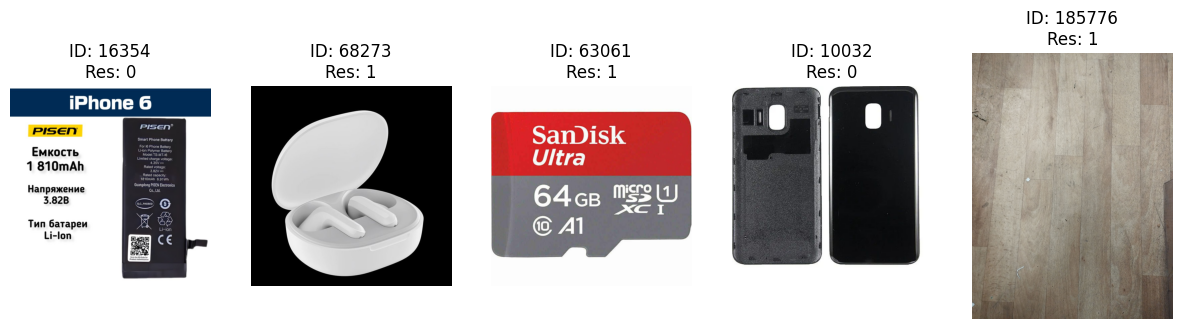

In [82]:
train_df = pd.read_csv("../data/ml_ozon_сounterfeit_train.csv")

sample = train_df.dropna(subset=["description"]).sample(5, random_state=47)
train_img_folder = "C:/Users/Kostya/Desktop/CodeNRockHack/CounterfeitDetector/data/ml_ozon_сounterfeit_train_images"

plt.figure(figsize=(15,10))
for i, row in enumerate(sample.itertuples(), 1):
    img_path = os.path.join(train_img_folder, f"{row.ItemID}.png")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"ID: {row.ItemID}\nRes: {row.resolution}")
        print(f"ID {row.ItemID} | res={row.resolution}\n"
              f"Название: {row.name_rus}\n"
              f"Описание: {row.description}\n"
              f"Цена: {row.PriceDiscounted}\n")
plt.show()


In [88]:
from pathlib import Path
import re
import pandas as pd

train_csv = "../data/ml_ozon_сounterfeit_train.csv"
img_folder = Path(r"C:/Users/Kostya/Desktop/CodeNRockHack/CounterfeitDetector/data/ml_ozon_сounterfeit_train_images")

train = pd.read_csv(train_csv, nrows=10000)
train['ItemID_str'] = train['ItemID'].astype(str)

# собрать список файлов и маппинг по stem и по первой встреченной цифре (ItemID)
files = [p for p in img_folder.rglob("*") if p.is_file()]
stem_map = {p.stem: str(p) for p in files}

num_map = {}
for p in files:
    m = re.search(r'(\d{4,})', p.stem)
    if m:
        key = m.group(1)
        if key not in num_map:
            num_map[key] = str(p)

print("Found files:", len(files))
# функция поиска (используй далее)
def find_image(itemid_str):
    if itemid_str in stem_map:
        return stem_map[itemid_str]
    if itemid_str in num_map:
        return num_map[itemid_str]
    # fallback: find any stem containing the id (slow)
    for s,p in stem_map.items():
        if itemid_str in s:
            return p
    return None


Found files: 196460


Matched: 9972
class 0 — mean: 1093.0, median: 900.0, count: 9667
class 1 — mean: 1193.5, median: 1000.0, count: 305


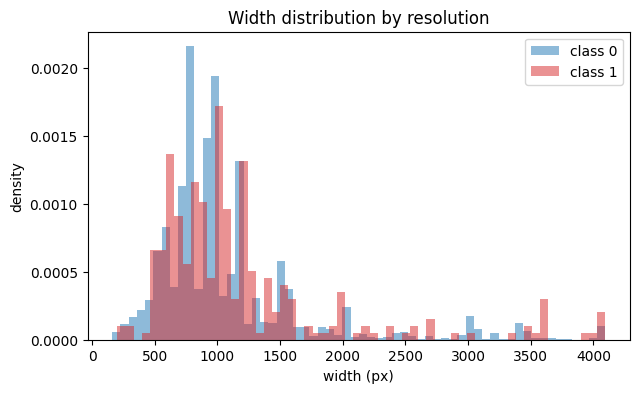

In [89]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

widths = []
ids = []
paths = []
for iid in train['ItemID_str'].unique():
    p = find_image(iid)
    if p is None: 
        continue
    try:
        with Image.open(p) as im:
            w,h = im.size
    except Exception:
        continue
    widths.append(w)
    ids.append(iid)
    paths.append(p)

df_w = pd.DataFrame({"ItemID_str": ids, "width": widths, "img_path": paths})
merged = train.merge(df_w, on="ItemID_str", how="inner")
print("Matched:", len(merged))

for cls in [0,1]:
    s = merged[merged['resolution']==cls]['width'].dropna()
    print(f"class {cls} — mean: {s.mean():.1f}, median: {s.median():.1f}, count: {len(s)}")

# plot (normalized)
plt.figure(figsize=(7,4))
for cls,color in zip([0,1], ['C0','C3']):
    s = merged[merged['resolution']==cls]['width'].dropna()
    if len(s)>0:
        plt.hist(s, bins=60, density=True, alpha=0.5, label=f'class {cls}', color=color)
plt.xlabel('width (px)')
plt.ylabel('density')
plt.title('Width distribution by resolution')
plt.legend()
plt.show()


Matched: 9972
class 0 — mean: 1161.7, median: 1000.0, count: 9667
class 1 — mean: 1193.1, median: 1000.0, count: 305


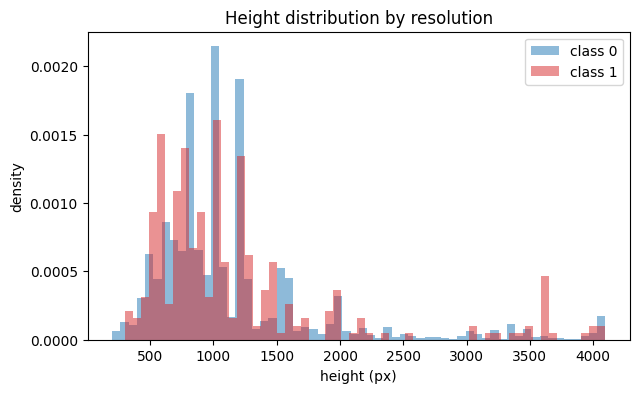

In [90]:
from PIL import Image
import matplotlib.pyplot as plt

heights = []
ids = []
for iid in train['ItemID_str'].unique():
    p = find_image(iid)
    if p is None: 
        continue
    try:
        with Image.open(p) as im:
            w,h = im.size
    except Exception:
        continue
    heights.append(h)
    ids.append(iid)

df_h = pd.DataFrame({"ItemID_str": ids, "height": heights})
merged_h = train.merge(df_h, on="ItemID_str", how="inner")
print("Matched:", len(merged_h))

for cls in [0,1]:
    s = merged_h[merged_h['resolution']==cls]['height'].dropna()
    print(f"class {cls} — mean: {s.mean():.1f}, median: {s.median():.1f}, count: {len(s)}")

plt.figure(figsize=(7,4))
for cls,color in zip([0,1], ['C0','C3']):
    s = merged_h[merged_h['resolution']==cls]['height'].dropna()
    if len(s)>0:
        plt.hist(s, bins=60, density=True, alpha=0.5, label=f'class {cls}', color=color)
plt.xlabel('height (px)')
plt.ylabel('density')
plt.title('Height distribution by resolution')
plt.legend()
plt.show()


In [93]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 660.6 kB/s eta 0:00:03
   - -------------------------------------- 0.0/1.5 MB 393.8 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.5 MB 819.2 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.5 MB 1.2 MB/s eta 0:00:02
   ----------- ---------------------------- 0.4/1.5 MB 1.9 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.5 MB 1.8 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.5 MB 2.3 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.5 MB 2.3 MB/s eta 0:00:01
   ------------------------------- -------- 1.2/1.5 MB 3.1 MB/s eta 0:00:01
   --------------------------------- ------ 1.2/1.5 MB 2.8 MB/s eta 0:00:01
   --------------------------------- ------ 1.2/1.5 MB 2.8 MB/s eta 0:00:01
   --------------------------------- ------ 1.2/1.5 MB 2.8 MB/s eta 0:00:01
   ----------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd, numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from scipy import sparse
import lightgbm as lgb

TRAIN_CSV = "../data/ml_ozon_сounterfeit_train.csv"
TEXT_COLS = ["name_rus", "description"]
CAT_COLS = ["brand_name", "CommercialTypeName4"]   
TARGET = "resolution"
ID_COL = "id"   

N_FOLDS = 5
RANDOM_STATE = 42

df = pd.read_csv(TRAIN_CSV)

df[TARGET] = df[TARGET].astype(int)

exclude = {ID_COL, "ItemID", "SellerID", TARGET}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]
cat_cols = [c for c in CAT_COLS if c in df.columns]

print("Numeric cols:", num_cols)
print("Cat cols:", cat_cols)
print("Text cols:", [c for c in TEXT_COLS if c in df.columns])

for c in cat_cols:
    counts = df[c].fillna("##NA##").value_counts(dropna=False).to_dict()
    df[c + "_freq"] = df[c].fillna("##NA##").map(counts).astype(float)
cat_freq_cols = [c + "_freq" for c in cat_cols]

X_num = df[num_cols].copy()
imp = SimpleImputer(strategy="median")
X_num_imp = imp.fit_transform(X_num)          
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_imp)

texts = []
for i, row in df.iterrows():
    pieces = []
    for c in TEXT_COLS:
        if c in df.columns:
            pieces.append(str(row.get(c, "")) if pd.notna(row.get(c, "")) else "")
    texts.append(" ".join(pieces))
tf = TfidfVectorizer(max_features=80_000, ngram_range=(1,2))
X_text = tf.fit_transform(texts) 

if cat_freq_cols:
    X_catfreq = df[cat_freq_cols].fillna(0).values
else:
    X_catfreq = np.zeros((len(df), 0))

X_num_sparse = sparse.csr_matrix(X_num_scaled)
X_cat_sparse = sparse.csr_matrix(X_catfreq)
X = sparse.hstack([X_text, X_cat_sparse, X_num_sparse], format="csr")
y = df[TARGET].values

print("Feature matrix shape:", X.shape)

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
oof = np.zeros(len(df))
fold_scores = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    clf = lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=31,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight='balanced'   # handle imbalance
    )
    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='binary_logloss'
    )

    pval = clf.predict_proba(X_va)[:,1]
    ths = np.linspace(0.01, 0.99, 99)
    best_th, best_f1 = 0.5, 0.0
    for t in ths:
        f = f1_score(y_va, (pval >= t).astype(int))
        if f > best_f1:
            best_f1 = f
            best_th = t

    oof[va_idx] = (pval >= best_th).astype(int)
    f1_fold = f1_score(y_va, oof[va_idx])
    fold_scores.append(f1_fold)
    print(f"Fold {fold} -> best_th={best_th:.3f} | val F1={f1_fold:.4f}")

print("CV folds F1:", fold_scores)
print("OOF F1:", f1_score(y, oof))


Numeric cols: ['rating_1_count', 'rating_2_count', 'rating_3_count', 'rating_4_count', 'rating_5_count', 'comments_published_count', 'photos_published_count', 'videos_published_count', 'PriceDiscounted', 'item_time_alive', 'item_count_fake_returns7', 'item_count_fake_returns30', 'item_count_fake_returns90', 'item_count_sales7', 'item_count_sales30', 'item_count_sales90', 'item_count_returns7', 'item_count_returns30', 'item_count_returns90', 'GmvTotal7', 'GmvTotal30', 'GmvTotal90', 'ExemplarAcceptedCountTotal7', 'ExemplarAcceptedCountTotal30', 'ExemplarAcceptedCountTotal90', 'OrderAcceptedCountTotal7', 'OrderAcceptedCountTotal30', 'OrderAcceptedCountTotal90', 'ExemplarReturnedCountTotal7', 'ExemplarReturnedCountTotal30', 'ExemplarReturnedCountTotal90', 'ExemplarReturnedValueTotal7', 'ExemplarReturnedValueTotal30', 'ExemplarReturnedValueTotal90', 'ItemVarietyCount', 'ItemAvailableCount', 'seller_time_alive']
Cat cols: ['brand_name', 'CommercialTypeName4']
Text cols: ['name_rus', 'descrip

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 -> best_th=0.660 | val F1=0.8150
[LightGBM] [Info] Number of positive: 10441, number of negative: 147317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 49.269768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2256785
[LightGBM] [Info] Number of data points in the train set: 157758, number of used features: 69755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 -> best_th=0.630 | val F1=0.8247
[LightGBM] [Info] Number of positive: 10441, number of negative: 147317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 42.790329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2255220
[LightGBM] [Info] Number of data points in the train set: 157758, number of used features: 69699
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 -> best_th=0.700 | val F1=0.8183
[LightGBM] [Info] Number of positive: 10442, number of negative: 147317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 42.772599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2255345
[LightGBM] [Info] Number of data points in the train set: 157759, number of used features: 69590
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 -> best_th=0.760 | val F1=0.8233
[LightGBM] [Info] Number of positive: 10442, number of negative: 147317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 43.787857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2250354
[LightGBM] [Info] Number of data points in the train set: 157759, number of used features: 69632
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 -> best_th=0.760 | val F1=0.8236
CV folds F1: [0.8150203477617463, 0.8247041420118343, 0.8182861514919664, 0.8233236151603499, 0.823552049259188]
OOF F1: 0.820952092177077


OSError: Cannot save file into a non-existent directory: 'out'

In [96]:

# ---------- Save OOF and vectorizer/scaler for inference ----------
df_oof = df[[ID_COL]].copy() if ID_COL in df.columns else df.reset_index()[["index"]].rename(columns={"index":"id"})
df_oof["oof_pred"] = oof.astype(int)
df_oof[TARGET] = y
df_oof.to_csv("../out/oof_baseline_text_tabular.csv", index=False)
print("Saved out/oof_baseline_text_tabular.csv")


Saved out/oof_baseline_text_tabular.csv


In [98]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true, oof_preds, oof_probs у тебя уже есть после CV
# (oof_probs – вероятности, oof_preds – бинарные метки с оптимальным threshold)

print("OOF Precision:", precision_score(y, oof_preds))
print("OOF Recall:", recall_score(y, oof_preds))
print("OOF F1:", f1_score(y, oof_preds))

# Confusion matrix
cm = confusion_matrix(y, oof_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Оригинал", "Контрафакт"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (OOF)")
plt.show()


NameError: name 'oof_preds' is not defined